In [123]:
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
import torch

from src.geometry.point_transformation import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.splats.splats_utils import *
import itertools

In [3]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Initializing covariances for Gaussian Splats 

In the paper they initialize covariances as isotropic with axes equal to the distance to the 3 nearest neighbours. But for now I initialized it from uniform distribution



In [127]:
diagonal = np.array([[1.0, 0, 0], [0, 1.0, 0], [0, 0, 1.0]])

In [5]:
torch.autograd.set_detect_anomaly(True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
requires_grad = True

In [7]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'
output_path = scene_folder / 'undistorted_images'

pcd = o3d.io.read_point_cloud(str(scene_folder / 'sparse.ply'))
# pcd.compute_mean_and_covariance()
# pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=3)) 
points = torch.tensor(np.asarray(pcd.points), device=device, requires_grad=requires_grad, dtype=torch.float32)
colors = torch.tensor(np.asarray(pcd.colors), device=device, requires_grad=requires_grad, dtype=torch.float32)
covariances = torch.tensor(init_from_uniform(len(points)), device=device, dtype=torch.float32) # np.asarray(pcd.covariances)

In [8]:
covariances[0]

tensor([[0.1177, 0.0000, 0.0000],
        [0.0000, 0.1177, 0.0000],
        [0.0000, 0.0000, 0.1177]], device='cuda:0')

In [9]:
def convert_to_homogenous(points: torch.Tensor):
    return torch.concatenate((points, torch.ones((len(points), 1), dtype=torch.float32, device=device)), dim=1)

def to_ndc_coordinates(clip_coordinates):
    '''
    Converts to Normalized Device Coordinates
    :param clip_coordinates:
    :return:
    '''
    ndc_coordinates = clip_coordinates[:, :3] / clip_coordinates[:, 3:]
    return ndc_coordinates


def to_screen_coordinates(ndc_coordinates, width, height, zfar, znear):
    x_off, y_off = 0, 0

    screen_coordinates = torch.zeros_like(ndc_coordinates)

    screen_coordinates[:, 0] = x_off + 0.5 * (-ndc_coordinates[:, 0] + 1) * width
    screen_coordinates[:, 1] = y_off + 0.5 * (-ndc_coordinates[:, 1] + 1) * height
    screen_coordinates[:, 2] = 0.5 * (zfar - znear) * ndc_coordinates[:, 2] + 0.5 * (zfar + znear)  # can be used to resolve depth
    return screen_coordinates


In [10]:
reconstruction = pycolmap.Reconstruction(output_path / 'sparse')

img_id = 1
img = reconstruction.images[img_id]
cam_id = 1

extrinsic_matrix = get_extrinsic_params(img.cam_from_world)
f, cx, cy = reconstruction.cameras[cam_id].params
width, height = reconstruction.cameras[cam_id].width, reconstruction.cameras[cam_id].height
znear, zfar = 1, 5
intrinsic_matrix = get_intrinsic_opengl_params(f, f, height, width, zfar=zfar, znear=znear)
W = torch.tensor(extrinsic_matrix[:3, :3].T, device=device, dtype=torch.float32) # viewing transformation

extrinsic_matrix_pt = torch.tensor(extrinsic_matrix, device=device, dtype=torch.float32)
intrinsic_matrix_pt = torch.tensor(intrinsic_matrix, device=device, dtype=torch.float32)

homogeneous_points = convert_to_homogenous(points)
camera_coordinates = homogeneous_points @ extrinsic_matrix_pt.T
clip_coordinates = camera_coordinates @ intrinsic_matrix_pt.T
point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)

ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
c = colors[point_ids]

screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)
cov_3d = covariances[point_ids]

In [11]:
f_pt = torch.scalar_tensor(f, device=device, dtype=torch.float32)

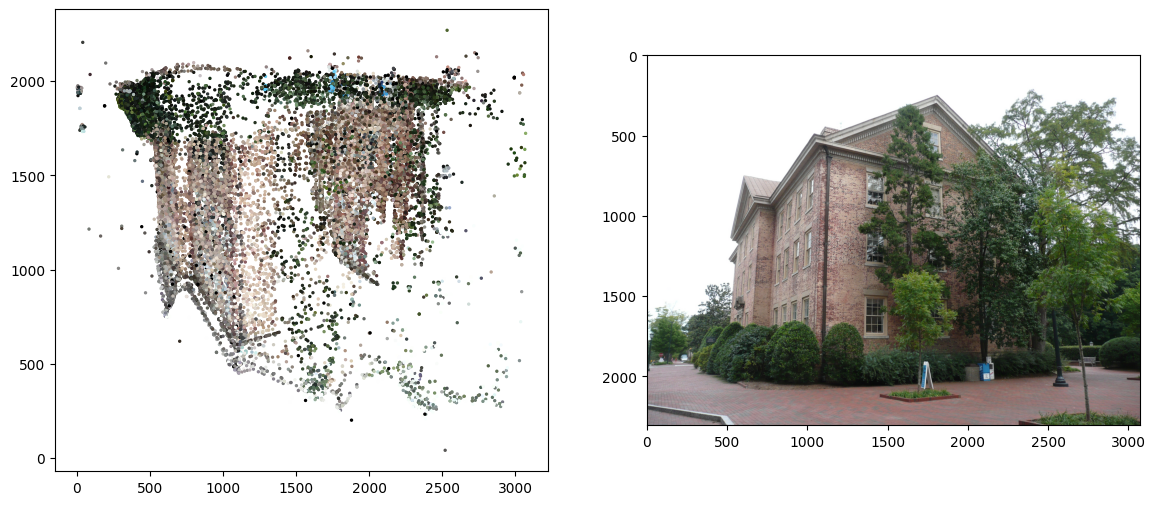

In [12]:
screen_coordinates_np = screen_coordinates.clone().detach().to('cpu')
image = mpimg.imread(images_folder / f'{img.name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(screen_coordinates_np[:, 0], screen_coordinates_np[:, 1], s=2, c=c.clone().detach().to('cpu'))
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()

In [13]:
print(f"# filtered points {sum(point_ids)}")
print(f"# total points {reconstruction.num_points3D()}")

# filtered points 33008
# total points 57713


In [14]:
n = sum(point_ids)

This is how our ground truth looks like - it is an image from a given camera 

In [15]:
print("Image shape: ", image.shape)
print(image[500, 500])

Image shape:  (2304, 3072, 3)
[255 255 255]


#### Initialization

We will optimize the attributes of Gaussians:
- coordinates $[x, y, z]$ (initialized from SFM)
- color (in original paper they use SH, but I think that RGB color is simpler as for now)
- alpha = opacity
- covariance matrix

we'll use pytorch to train these parameters (even though we don't have a model)

In [16]:
alphas_exponents_pt = torch.rand(n, requires_grad=requires_grad, device=device, dtype=torch.float32) * 6 - 3 

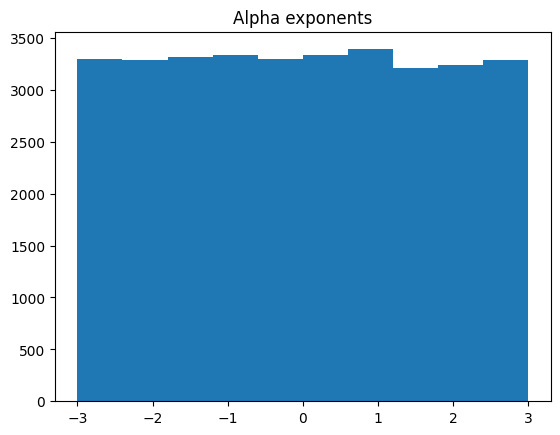

In [17]:
plt.hist(alphas_exponents_pt.detach().cpu())
_ = plt.title('Alpha exponents')

We'll use initialized covariances to set up values for scale exponents and rotation matrices

In [18]:
cov_3d

tensor([[[0.1177, 0.0000, 0.0000],
         [0.0000, 0.1177, 0.0000],
         [0.0000, 0.0000, 0.1177]],

        [[0.1324, 0.0000, 0.0000],
         [0.0000, 0.1324, 0.0000],
         [0.0000, 0.0000, 0.1324]],

        [[0.2760, 0.0000, 0.0000],
         [0.0000, 0.2760, 0.0000],
         [0.0000, 0.0000, 0.2760]],

        ...,

        [[0.2701, 0.0000, 0.0000],
         [0.0000, 0.2701, 0.0000],
         [0.0000, 0.0000, 0.2701]],

        [[0.1128, 0.0000, 0.0000],
         [0.0000, 0.1128, 0.0000],
         [0.0000, 0.0000, 0.1128]],

        [[0.2763, 0.0000, 0.0000],
         [0.0000, 0.2763, 0.0000],
         [0.0000, 0.0000, 0.2763]]], device='cuda:0')

In [19]:
eigenvalues, eigenvectors = torch.linalg.eig(cov_3d)

In [20]:
eigenvalues.real

tensor([[0.1177, 0.1177, 0.1177],
        [0.1324, 0.1324, 0.1324],
        [0.2760, 0.2760, 0.2760],
        ...,
        [0.2701, 0.2701, 0.2701],
        [0.1128, 0.1128, 0.1128],
        [0.2763, 0.2763, 0.2763]], device='cuda:0')

In [21]:
lower = 1e-20 # add some small value to prevent 0 as log argument

rot = eigenvectors.real.requires_grad_(requires_grad)

# Similarly to alphas we'll actually optimize exponents
scale = torch.sqrt(torch.abs(eigenvalues.real[:, np.newaxis])) * torch.repeat_interleave(torch.tensor(diagonal[np.newaxis, ...], device=device), n, axis=0)
scale_exponents = torch.log(scale).requires_grad_(requires_grad)
scale_exponents.shape

torch.Size([33008, 3, 3])

leaf components are at the top of the computational graph and they represent the variables we want to optimize

In [22]:
scale_exponents.is_leaf

True

In [23]:
scale_exponents

tensor([[[-1.0696,    -inf,    -inf],
         [   -inf, -1.0696,    -inf],
         [   -inf,    -inf, -1.0696]],

        [[-1.0111,    -inf,    -inf],
         [   -inf, -1.0111,    -inf],
         [   -inf,    -inf, -1.0111]],

        [[-0.6436,    -inf,    -inf],
         [   -inf, -0.6436,    -inf],
         [   -inf,    -inf, -0.6436]],

        ...,

        [[-0.6544,    -inf,    -inf],
         [   -inf, -0.6544,    -inf],
         [   -inf,    -inf, -0.6544]],

        [[-1.0910,    -inf,    -inf],
         [   -inf, -1.0910,    -inf],
         [   -inf,    -inf, -1.0910]],

        [[-0.6432,    -inf,    -inf],
         [   -inf, -0.6432,    -inf],
         [   -inf,    -inf, -0.6432]]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [24]:
rot

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        ...,

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0', requires_grad=True)

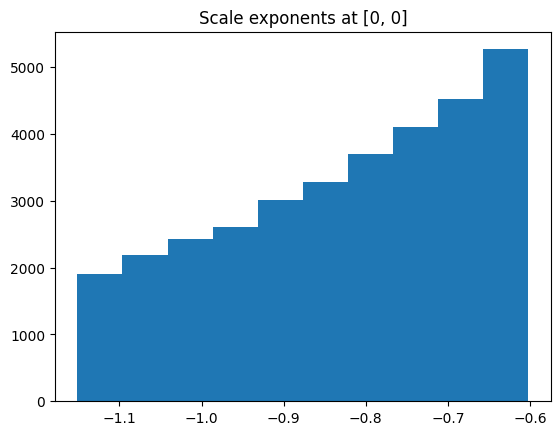

In [25]:
plt.hist(scale_exponents[:, 0, 0].clone().detach().cpu())
# plt.hist(scale[0, 0].detach().cpu())
_ = plt.title('Scale exponents at [0, 0]')

#### Pseudo algorithm

Below I tried to follow the steps from the paper (but some are skipped)

We can actually start training with lower resolution images (but then a new point cloud needs to be created)

In [26]:
width, height

(3072, 2304)

Filter splats that have means within a chosen tile - later we will probably need to come up with smarter way to assign gaussians to splats

In [27]:
coor = 1000
tile_size = 32
tile_left_lower, tile_upper_right = np.array([coor, coor]), np.array([coor + tile_size, coor + tile_size])

In [28]:
ids = (screen_coordinates[:, 0] > tile_left_lower[0]) & (screen_coordinates[:, 1] > tile_left_lower[1]) & (screen_coordinates[:, 0] < tile_upper_right[0]) & (screen_coordinates[:, 1] < tile_upper_right[1]) 
torch.sum(ids)

tensor(15, device='cuda:0')

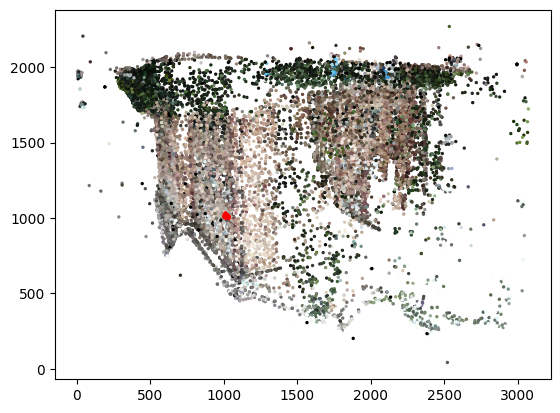

In [29]:
plt.scatter(screen_coordinates[~ids, 0].cpu().detach().numpy(), screen_coordinates[~ids, 1].cpu().detach().numpy(), s=2, c=c[~(ids.cpu().detach().numpy())].cpu().detach().numpy(), label='within a tile')
plt.scatter(screen_coordinates[ids, 0].cpu().detach().numpy(), screen_coordinates[ids, 1].cpu().detach().numpy(), s=5, c='red', label='outside')

In [30]:
splat_indexes = torch.where(ids == True)[0]
splat_indexes # indices of splats intersecting a chosen tile

tensor([  855,   873,   881,  1701,  4646,  5339,  6304,  6519,  6609, 14968,
        15128, 17410, 18007, 21377, 29822], device='cuda:0')

According to the original algorithm we also sort splats by their *z* coordinate  

In [31]:
z_sorted = screen_coordinates[splat_indexes, 2].sort()

In [32]:
z_indices = z_sorted.indices.type(torch.int)
print(z_indices)

tensor([ 6,  8,  5,  0,  4,  7,  1,  9,  2, 10, 13, 12, 14,  3, 11],
       device='cuda:0', dtype=torch.int32)


In [33]:
splat_z_indexes = splat_indexes[z_indices]
print(splat_z_indexes)

tensor([ 6304,  6609,  5339,   855,  4646,  6519,   873, 14968,   881, 15128,
        21377, 18007, 29822,  1701, 17410], device='cuda:0')


In [34]:
screen_coordinates[splat_z_indexes]

tensor([[1001.3662, 1018.9285,    6.3706],
        [1006.4677, 1011.2070,    6.3721],
        [1005.0593, 1022.6404,    6.3751],
        [1003.3591, 1014.9603,    6.3752],
        [1004.9011, 1007.0420,    6.3755],
        [1005.8243, 1024.5929,    6.3796],
        [1013.4578, 1020.7559,    6.3861],
        [1023.5831, 1017.4077,    6.3950],
        [1023.4136, 1017.8189,    6.3951],
        [1025.9486, 1005.9556,    6.3960],
        [1029.1620, 1004.7127,    6.3990],
        [1027.9734, 1014.9981,    6.3994],
        [1028.3237, 1003.6097,    6.4009],
        [1029.5161, 1014.3641,    6.4017],
        [1006.3964, 1030.1541,    6.4351]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [35]:
tile_pixels = np.array(list(itertools.product(range(coor, coor + tile_size), range(coor, coor + tile_size))))

In [36]:
tile_pixels # coordinates of pixels that lie within a chosen tile

array([[1000, 1000],
       [1000, 1001],
       [1000, 1002],
       ...,
       [1031, 1029],
       [1031, 1030],
       [1031, 1031]])

In [37]:
pixel = torch.tensor([coor + 16, coor + 16], device=device) # choose one pixel to be rendered

In [38]:
image_pt = torch.tensor(image / 255.0, device=device) # normalize color

In [39]:
# Camera coordinates are used to compute jacobian
# Formula inspired by the series of notebooks on medium 
class JacobianOps(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, cam_points, focal):
        ctx.save_for_backward(cam_points, focal)
        
        jacs = torch.zeros(len(cam_points), 3, 3, device=device, dtype=torch.float32)
        
        jacs[:, 0, 0] = focal / cam_points[:, 2]
        jacs[:, 1, 1] = focal / cam_points[:, 2]
        jacs[:, 2, 0] = -focal * cam_points[:, 0] / (cam_points[:, 2] ** 2)
        jacs[:, 2, 1] = -focal * cam_points[:, 1] / (cam_points[:, 2] ** 2)
        
        return jacs
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        points, focal = ctx.saved_tensors
        
        grad_points = torch.zeros_like(points)
        
        grad_points[:, 2] = grad_output[:, 0, 0] * (-focal / points[:, 2] ** 2) + grad_output[:, 1, 1] * (-focal / points[:, 2] ** 2)
        grad_points[:, 2] += grad_output[:, 2, 0] * (2 * focal * points[:, 0] / (points[:, 2] ** 3)) + grad_output[:, 2, 1] * (2 * focal * points[:, 1] / (points[:, 2] ** 3))
        grad_points[:, 0] = grad_output[:, 2, 0] * (-focal / (points[:, 2] ** 2))
        grad_points[:, 1] = grad_output[:, 2, 1] * (-focal / (points[:, 2] ** 2))
        
        return grad_points, None

In [40]:
def saturate(alphas):
    """
    Compute the number of Gaussians to consider until the saturation threshold (1.0) is reached
    :param alphas:
    :return: 
    """
    i = 0
    alpha_sum = 0
    while alpha_sum < 1.0 and i < len(alphas):
        alpha_sum += alphas[i]
        i += 1
    return i - 1

In [41]:
splat_rot = rot[splat_z_indexes]
splat_scale = torch.exp(scale_exponents[splat_z_indexes]).type(torch.float32)
splat_rs = torch.bmm(splat_rot, splat_scale)

splat_covs = torch.bmm(splat_rs, splat_rs.transpose(1, 2))

Js = JacobianOps.apply
jacobians = Js(camera_coordinates[splat_z_indexes], f_pt)

W_splats = torch.repeat_interleave(W[torch.newaxis, ...], repeats=len(splat_z_indexes), dim=0)
M = torch.bmm(jacobians, W_splats)
proj_covs = torch.bmm(torch.bmm(M, splat_covs), M.transpose(1, 2))[:, :2, :2]

projs_inv = torch.linalg.inv(proj_covs)

pixel_pt = torch.repeat_interleave(pixel[torch.newaxis, ...], repeats=len(splat_z_indexes), dim=0)

diff = (pixel_pt - screen_coordinates[splat_z_indexes, :2])[:, :, torch.newaxis]
H = torch.bmm(diff.transpose(1, 2), projs_inv)
g_vals = torch.exp(-1 / 2 * torch.bmm(H, diff)).reshape(len(splat_indexes))

alphas = torch.sigmoid(alphas_exponents_pt[splat_z_indexes]).type(torch.float32)
saturation_depth = saturate(alphas)

weights = alphas[:saturation_depth] * g_vals[:saturation_depth]
color = weights.reshape(1, saturation_depth) @ colors[splat_z_indexes[:saturation_depth]]

loss = torch.sum(torch.abs(color - image_pt[pixel[0], pixel[1]]))

In [42]:
loss.backward()

In [43]:
points.grad[splat_z_indexes[:saturation_depth]]

tensor([[-3.1779e-04, -4.3396e-05,  1.8663e-04]], device='cuda:0')

In [44]:
rot.grad[splat_z_indexes[:saturation_depth]]

tensor([[[-0.0002,  0.0002,  0.0004],
         [ 0.0002, -0.0002, -0.0004],
         [ 0.0004, -0.0004, -0.0008]]], device='cuda:0')

In [45]:
scale_exponents.grad[splat_z_indexes[:saturation_depth]]

tensor([[[-0.0002,  0.0000,  0.0000],
         [ 0.0000, -0.0002,  0.0000],
         [ 0.0000,  0.0000, -0.0008]]], device='cuda:0', dtype=torch.float64)

#### Computations step-by-step

In [46]:
Js = JacobianOps.apply

In [47]:
camera_coordinates[splat_z_indexes]

tensor([[-0.6723, -0.2449,  3.0473,  1.0000],
        [-1.8243,  0.8520,  4.7638,  1.0000],
        [-1.1592, -0.2733,  3.7446,  1.0000],
        [-0.6376, -1.0639,  4.8485,  1.0000],
        [-1.3976,  0.8417,  3.8990,  1.0000],
        [-0.8424, -0.1989,  3.4392,  1.0000],
        [-0.6377, -0.1801,  2.9637,  1.0000],
        [-0.6446, -0.1282,  2.9689,  1.0000],
        [-1.5047, -0.5309,  4.4290,  1.0000],
        [-1.1669,  0.5175,  3.6211,  1.0000],
        [-0.5991, -0.1061,  2.8737,  1.0000],
        [-2.1045,  1.2596,  5.5795,  1.0000],
        [-2.2850,  0.6251,  6.1350,  1.0000],
        [-1.8920,  0.2504,  5.3649,  1.0000],
        [-1.9467,  0.8973,  5.3284,  1.0000]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [48]:
jacobians = Js(camera_coordinates[splat_z_indexes], f_pt)

In [49]:
camera_coordinates[0]

tensor([-1.2793,  0.5344,  3.7289,  1.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [50]:
jacobians[0]

tensor([[851.8366,   0.0000,   0.0000],
        [  0.0000, 851.8366,   0.0000],
        [187.9451,  68.4566,   0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [51]:
W_splats = torch.repeat_interleave(W[torch.newaxis, ...], repeats=len(splat_z_indexes), dim=0)

In [52]:
M = torch.bmm(jacobians, W_splats)

In [53]:
proj_covs = torch.bmm(torch.bmm(M, splat_covs), M.transpose(1, 2))[:, :2, :2]

In [54]:
proj_covs[0]

tensor([[1.1940e+05, 0.0000e+00],
        [1.9531e-03, 1.1940e+05]], device='cuda:0', grad_fn=<SelectBackward0>)

In [55]:
proj_covs.shape

torch.Size([15, 2, 2])

In [56]:
projs_inv = torch.linalg.inv(proj_covs)

In [57]:
pixel_pt = torch.repeat_interleave(pixel[torch.newaxis, ...], repeats=len(splat_z_indexes), dim=0)

In [58]:
pixel

tensor([1016, 1016], device='cuda:0')

In [59]:
torch.exp(-1 / 2 * (pixel_pt - screen_coordinates[splat_z_indexes, :2])[:, torch.newaxis, :]).shape

torch.Size([15, 1, 2])

In [60]:
diff = (pixel_pt - screen_coordinates[splat_z_indexes, :2])[:, :, torch.newaxis]
H = torch.bmm(diff.transpose(1, 2), projs_inv)
g_vals = torch.exp(-1 / 2 * torch.bmm(H, diff)).reshape(len(splat_indexes))

In [61]:
g_vals

tensor([0.9991, 0.9987, 0.9993, 0.9978, 0.9982, 0.9992, 0.9999, 0.9998, 0.9997,
        0.9993, 0.9988, 0.9988, 0.9930, 0.9984, 0.9943], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [62]:
g_vals.shape

torch.Size([15])

In [63]:
alphas = torch.sigmoid(alphas_exponents_pt[splat_z_indexes]).type(torch.float32)

In [64]:
alphas.shape

torch.Size([15])

In [65]:
saturation_depth = saturate(alphas)

In [66]:
alphas[:saturation_depth]

tensor([0.3145], device='cuda:0', grad_fn=<SliceBackward0>)

In [67]:
weights = alphas[:saturation_depth] * g_vals[:saturation_depth]
weights

tensor([0.3142], device='cuda:0', grad_fn=<MulBackward0>)

In [68]:
colors[splat_z_indexes[:saturation_depth]].shape

torch.Size([1, 3])

In [69]:
color = weights.reshape(1, saturation_depth) @ colors[splat_z_indexes[:saturation_depth]]

In [70]:
color

tensor([[0.2193, 0.1959, 0.1910]], device='cuda:0', grad_fn=<MmBackward0>)

In [71]:
screen_coordinates[splat_z_indexes]

tensor([[1001.3662, 1018.9285,    6.3706],
        [1006.4677, 1011.2070,    6.3721],
        [1005.0593, 1022.6404,    6.3751],
        [1003.3591, 1014.9603,    6.3752],
        [1004.9011, 1007.0420,    6.3755],
        [1005.8243, 1024.5929,    6.3796],
        [1013.4578, 1020.7559,    6.3861],
        [1023.5831, 1017.4077,    6.3950],
        [1023.4136, 1017.8189,    6.3951],
        [1025.9486, 1005.9556,    6.3960],
        [1029.1620, 1004.7127,    6.3990],
        [1027.9734, 1014.9981,    6.3994],
        [1028.3237, 1003.6097,    6.4009],
        [1029.5161, 1014.3641,    6.4017],
        [1006.3964, 1030.1541,    6.4351]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [72]:
loss = torch.sum(torch.abs(color - image_pt[pixel[0], pixel[1]]))

In [73]:
loss

tensor(1.0448, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)

### Training for pixels in a tile

In [128]:
scene_folder = Path('../data/south-building-d4x')
output_path = scene_folder / 'undistorted_images'
images_folder = scene_folder / 'images'

pcd = o3d.io.read_point_cloud(str(scene_folder / 'sparse.ply'))
points = torch.tensor(np.asarray(pcd.points), device=device, requires_grad=requires_grad, dtype=torch.float32)
colors = torch.tensor(np.asarray(pcd.colors), device=device, requires_grad=requires_grad, dtype=torch.float32)
covariances = torch.tensor(init_from_uniform(len(points)), device=device, dtype=torch.float32) 
alphas_exponents_pt = torch.tensor(np.log(np.random.uniform(low=0.1, high=0.5, size=len(pcd.points))), requires_grad=requires_grad, device=device, dtype=torch.float32)

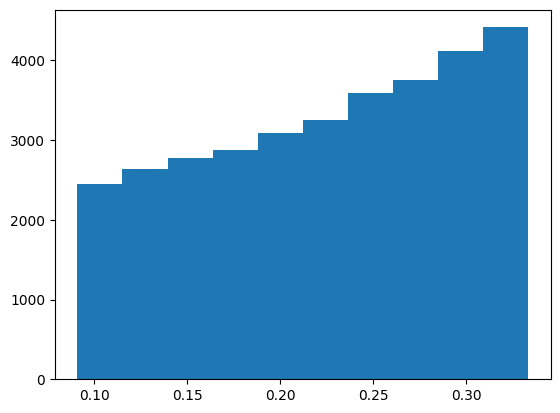

In [129]:
_ = plt.hist(torch.sigmoid(alphas_exponents_pt.cpu().detach()).numpy())

In [94]:
reconstruction = pycolmap.Reconstruction(output_path / 'sparse')

img_id = 1
img = reconstruction.images[img_id]
cam_id = 1
image = mpimg.imread(images_folder / f'{img.name}')

extrinsic_matrix = get_extrinsic_params(img.cam_from_world)
f, cx, cy = reconstruction.cameras[cam_id].params
f_pt = torch.scalar_tensor(f, device=device, dtype=torch.float32)
width, height = reconstruction.cameras[cam_id].width, reconstruction.cameras[cam_id].height
znear, zfar = 1, 5
intrinsic_matrix = get_intrinsic_opengl_params(f, f, height, width, zfar=zfar, znear=znear)
W = torch.tensor(extrinsic_matrix[:3, :3].T, device=device, dtype=torch.float32) # viewing transformation

extrinsic_matrix_pt = torch.tensor(extrinsic_matrix, device=device, dtype=torch.float32)
intrinsic_matrix_pt = torch.tensor(intrinsic_matrix, device=device, dtype=torch.float32)

image_pt = torch.tensor(image / 255.0, device=device)

In [95]:
homogeneous_points = convert_to_homogenous(points)
camera_coordinates = homogeneous_points @ extrinsic_matrix_pt.T
clip_coordinates = camera_coordinates @ intrinsic_matrix_pt.T
point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)
ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)

n = sum(point_ids)

In [96]:
eigenvalues, eigenvectors = torch.linalg.eig(covariances[point_ids])
rot = eigenvectors.real.requires_grad_(requires_grad)

# Similarly to alphas we'll actually optimize exponents
scale = torch.sqrt(torch.abs(eigenvalues.real[:, np.newaxis])) * torch.repeat_interleave(torch.tensor(diagonal[np.newaxis, ...], device=device), n, axis=0)
scale_exponents = torch.log(scale).requires_grad_(requires_grad)

In [97]:
coor = 500
tile_size = 32
tile_left_lower, tile_upper_right = np.array([coor, coor]), np.array([coor + tile_size, coor + tile_size])
pixel = torch.tensor([coor + 16, coor + 16], device=device) 
ids = (screen_coordinates[:, 0] > tile_left_lower[0]) & (screen_coordinates[:, 1] > tile_left_lower[1]) & (screen_coordinates[:, 0] < tile_upper_right[0]) & (screen_coordinates[:, 1] < tile_upper_right[1]) 
splat_indexes = torch.where(ids == True)[0]

In [98]:
tile_pixels = torch.tensor(list(itertools.product(range(coor, coor + tile_size), range(coor, coor + tile_size))), device=device)
tile_pixels

tensor([[500, 500],
        [500, 501],
        [500, 502],
        ...,
        [531, 529],
        [531, 530],
        [531, 531]], device='cuda:0')

In [99]:
points_before = points.detach().cpu().numpy()
colors_before = colors.detach().cpu().numpy()
rot_before = rot.detach().cpu().numpy()
scale_exponents_before = scale_exponents.detach().cpu().numpy()
alphas_exponents_before = alphas_exponents_pt.detach().cpu().numpy()

In [100]:
splat_indexes[screen_coordinates[splat_indexes, 2].sort().indices][:2]

tensor([11857, 10385], device='cuda:0')

In [101]:
image_pt

tensor([[[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [0.8353, 0.8549, 0.8706],
         [0.7647, 0.7843, 0.8000],
         [0.7412, 0.7608, 0.7765]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [0.8078, 0.8275, 0.8431],
         [0.8235, 0.8431, 0.8588],
         [0.9098, 0.9294, 0.9451]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [0.6941, 0.7098, 0.7216],
         [0.7451, 0.7608, 0.7725],
         [0.8902, 0.9059, 0.9176]],

        ...,

        [[0.6157, 0.5373, 0.5451],
         [0.6196, 0.5412, 0.5490],
         [0.6235, 0.5451, 0.5529],
         ...,
         [0.5843, 0.5294, 0.5294],
         [0.5922, 0.5294, 0.5333],
         [0.5922, 0.5294, 0.5333]],

        [[0.6157, 0.5373, 0.5451],
         [0.6157, 0.5373, 0.5451],
         [0.

In [102]:
height, width

(576, 768)

In [103]:
128 * 128

16384

In [104]:
tile_size

32

In [106]:
def tile_coords(width, height, tile_size):
    h_coords = range(0, height, tile_size)
    w_coords = range(0, width, tile_size)
    
    return list(itertools.product(h_coords, w_coords))

tile_coords(tile_size, tile_size, tile_size)

[(0, 0)]

In [107]:
offset = 200

In [108]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD([points, rot, scale_exponents, colors, alphas_exponents_pt], lr=0.001, momentum=0.9)
iterations = 20
tile_size = 32

running_loss = 0

for tile in tile_coords(tile_size, tile_size, tile_size):
    
    tile = list(tile)
    tile[0] += offset
    tile[1] += offset
    
    # points are optimized so we need to refresh calculations 
    homogeneous_points = convert_to_homogenous(points)
    camera_coordinates = homogeneous_points @ extrinsic_matrix_pt.T
    clip_coordinates = camera_coordinates @ intrinsic_matrix_pt.T
    point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)
    ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
    screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)
    
    tile_pixels = torch.tensor(list(itertools.product(range(tile[0], tile[0] + tile_size), range(tile[1], tile[1] + tile_size))), device=device)

    tile_left_lower, tile_upper_right = tile, np.array([tile[0] + tile_size, tile[1] + tile_size])
    ids = (screen_coordinates[:, 0] > tile_left_lower[0]) & (screen_coordinates[:, 1] > tile_left_lower[1]) & (
                screen_coordinates[:, 0] < tile_upper_right[0]) & (screen_coordinates[:, 1] < tile_upper_right[1])
    splat_indexes = torch.where(ids == True)[0]
    
    print(f"Tile: {tile}, # splats {len(splat_indexes)}")
    
    if len(splat_indexes) == 0:
        continue

    for pixel in tile_pixels:
        for i in range(iterations):
            optimizer.zero_grad()
            
            # points are optimized so we need to refresh calculations 
            homogeneous_points = convert_to_homogenous(points)
            camera_coordinates = homogeneous_points @ extrinsic_matrix_pt.T
            clip_coordinates = camera_coordinates @ intrinsic_matrix_pt.T
            point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)
            ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
            screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)
            
            # Gaussians depths may also change so we need to sort it again
            z_sorted = screen_coordinates[splat_indexes, 2].sort()
            z_indices = z_sorted.indices.type(torch.int)
            splat_z_indexes = splat_indexes[z_indices]
            
            # choose gaussians up to saturation
            alphas = torch.sigmoid(alphas_exponents_pt[splat_z_indexes]).type(torch.float32)
            saturation_depth = saturate(alphas)
            
            splat_indexes_f = splat_z_indexes[:saturation_depth]
         
            splat_rot = rot[splat_indexes_f]
            splat_scale = torch.exp(scale_exponents[splat_indexes_f]).type(torch.float32)
            splat_rs = torch.bmm(splat_rot, splat_scale)
            
            splat_covs = torch.bmm(splat_rs, splat_rs.transpose(1, 2))
            
            Js = JacobianOps.apply
            jacobians = Js(camera_coordinates[splat_indexes_f], f_pt)
            
            W_splats = torch.repeat_interleave(W[torch.newaxis, ...], repeats=len(splat_indexes_f), dim=0)
            M = torch.bmm(jacobians, W_splats)
            proj_covs = torch.bmm(torch.bmm(M, splat_covs), M.transpose(1, 2))[:, :2, :2]
            
            projs_inv = torch.linalg.inv(proj_covs)
            
            pixel_pt = torch.repeat_interleave(pixel[torch.newaxis, ...], repeats=len(splat_indexes_f), dim=0)
            
            diff = (pixel_pt - screen_coordinates[splat_indexes_f, :2])[:, :, torch.newaxis]
            H = torch.bmm(diff.transpose(1, 2), projs_inv)
            g_vals = torch.exp(-1 / 2 * torch.bmm(H, diff)).reshape(len(splat_indexes_f))
        
            weights = alphas[:saturation_depth] * g_vals
            color = weights.reshape(1, saturation_depth) @ colors[splat_indexes_f]
            
            loss = torch.sum(torch.abs(color - image_pt[pixel[0], pixel[1]])) 
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            print(f"[{pixel[0].item(), pixel[1].item()}][{i}] Loss = {loss.item()} Running loss = {running_loss}")
        
        running_loss = 0

Tile: [200, 200], # splats 191
[(200, 200)][0] Loss = 1.0652343831810298 Running loss = 1.0652343831810298
[(200, 200)][1] Loss = 1.0634391508850398 Running loss = 2.1286735340660696
[(200, 200)][2] Loss = 1.0600298248085323 Running loss = 3.188703358874602
[(200, 200)][3] Loss = 1.0551703475269618 Running loss = 4.243873706401564
[(200, 200)][4] Loss = 1.0490094624313655 Running loss = 5.29288316883293
[(200, 200)][5] Loss = 1.0416816376003566 Running loss = 6.334564806433287
[(200, 200)][6] Loss = 1.0333082876953426 Running loss = 7.36787309412863
[(200, 200)][7] Loss = 1.0239998005184474 Running loss = 8.391872894647078
[(200, 200)][8] Loss = 1.013855477407867 Running loss = 9.405728372054945
[(200, 200)][9] Loss = 1.0029648147377315 Running loss = 10.408693186792677
[(200, 200)][10] Loss = 0.9914087258133234 Running loss = 11.400101912606
[(200, 200)][11] Loss = 0.9792596004757227 Running loss = 12.379361513081724
[(200, 200)][12] Loss = 0.9665827058109583 Running loss = 13.3459442

In [109]:
alphas_exponents_pt[splat_indexes]

tensor([-0.6613, -0.0181, -1.7751, -0.5989, -0.3560, -1.3711, -0.6561, -0.2155,
        -0.2932, -1.0715, -1.0630, -0.3890, -1.5886, -0.4337, -1.7239, -0.4091,
        -0.2863, -1.1301, -1.1103, -0.6967, -0.1528, -0.5478, -0.7587, -1.1465,
        -0.5583, -0.8310, -0.8106, -1.3899, -2.0261, -0.2694, -1.2911, -1.0620,
        -0.1843, -1.1114, -0.2531, -1.7039, -0.6039, -1.2092, -0.8139, -1.3338,
        -0.0918, -0.5031, -1.8667, -0.3992, -0.9914, -0.5048, -0.1924, -0.0821,
        -0.5364, -0.1411,  0.2692, -0.3241, -1.2139, -0.8126, -0.2431, -1.9297,
        -1.3071, -0.0760, -1.9853, -0.7368, -0.3886, -0.0423, -0.3769, -0.0565,
        -0.3557, -0.4675, -0.1405, -0.1703, -1.7531, -1.5213, -0.5562, -1.8041,
        -0.5838, -2.0636, -0.4633, -0.3236, -1.3845, -2.1711, -0.7608, -0.7426,
        -0.1960, -0.8626, -0.7069, -0.4412, -1.4556, -0.4014, -1.0307, -0.8468,
        -1.4084, -0.5940, -0.7282, -0.6478, -0.3942, -0.2216, -0.8096, -0.4985,
        -1.4256, -0.5170, -1.5665, -0.36

In [110]:
alphas_exponents_before[splat_indexes.cpu()]

array([-0.5421215 , -0.01813491, -1.7751002 , -0.7011131 , -0.35603842,
       -1.3711107 , -0.6561049 , -0.21551552, -0.29315966, -1.0715268 ,
       -1.0630426 , -0.38899332, -1.588612  , -0.43369266, -1.7238905 ,
       -0.4091    , -0.2863332 , -1.1301032 , -0.6006563 , -0.6967154 ,
       -0.15278019, -0.5477647 , -0.758724  , -1.1465313 , -0.5582901 ,
       -0.83102906, -0.8106134 , -1.3899418 , -2.0260847 , -0.26935637,
       -1.2910875 , -1.0619526 , -0.18434723, -1.111443  , -0.25309667,
       -1.7039056 , -0.60387486, -1.2092115 , -0.81392014, -1.3337929 ,
       -0.09177659, -0.50307024, -1.8666836 , -0.39920807, -0.99142826,
       -0.50478613, -0.19238757, -0.08207787, -0.53644615, -0.14112815,
       -0.04762827, -0.324066  , -1.2138911 , -0.8125512 , -0.24305646,
       -1.9297147 , -1.3070953 , -0.07601124, -1.9852903 , -0.73684037,
       -0.3885967 , -0.05793577, -0.37690756, -0.05646893, -0.35568163,
       -0.46749547, -0.14047664, -0.1703319 , -1.7531143 , -1.52

In [111]:
alphas_exponents_before[splat_indexes.cpu()] - alphas_exponents_pt[splat_indexes].cpu().detach().numpy()

array([ 0.11913389,  0.        ,  0.        , -0.10219258,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.5096506 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.31680387,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.01566404,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [112]:
points[splat_indexes]

tensor([[-5.3797e-01, -1.9513e+00, -2.5272e-01],
        [-1.3421e+00, -4.8270e-01, -4.0280e-01],
        [-1.8475e+00, -8.0169e-01, -1.5659e-01],
        [-1.2417e+00, -2.0323e-01, -8.6548e-01],
        [ 4.5825e-01, -2.4171e-01, -7.1364e-01],
        [-2.1401e-01, -6.8218e-01, -3.5697e-01],
        [-8.6267e-01, -1.5180e-01, -6.0185e-01],
        [-1.0545e+00, -6.7251e-01, -3.5219e-01],
        [-7.4151e-01, -4.0399e-01, -4.1217e-01],
        [-1.4190e+00, -5.6870e-01, -3.7738e-01],
        [-6.6555e-01, -1.3206e-01, -6.2816e-01],
        [-4.3692e-01, -1.0107e+00, -2.6208e-01],
        [-1.3005e+00, -2.1922e-01, -8.6356e-01],
        [-6.4370e-01, -1.6963e+00, -5.0592e-02],
        [-1.4569e+00, -8.4436e-01, -2.9252e-01],
        [-5.1550e-01, -2.3825e-01, -4.8732e-01],
        [-6.8914e-01, -9.3546e-01, -2.8251e-01],
        [-2.0656e+00, -5.2104e-01, -2.3620e-01],
        [-4.6258e-01, -1.1074e+00, -2.1210e-01],
        [-6.9236e-01, -1.8417e+00, -7.5039e-02],
        [-1.8466e+00

In [113]:
points_before[splat_indexes.cpu().numpy()]

array([[-6.39482737e-01, -1.79400480e+00, -1.36544615e-01],
       [-1.34205532e+00, -4.82698947e-01, -4.02804494e-01],
       [-1.84745836e+00, -8.01687956e-01, -1.56593636e-01],
       [-1.30035579e+00, -2.19119728e-01, -8.64212215e-01],
       [ 4.58249897e-01, -2.41705909e-01, -7.13635266e-01],
       [-2.14012355e-01, -6.82182252e-01, -3.56970727e-01],
       [-8.62669230e-01, -1.51795924e-01, -6.01852000e-01],
       [-1.05446219e+00, -6.72506094e-01, -3.52185339e-01],
       [-7.41509914e-01, -4.03994322e-01, -4.12167907e-01],
       [-1.41895962e+00, -5.68698049e-01, -3.77375692e-01],
       [-6.65548623e-01, -1.32056177e-01, -6.28163338e-01],
       [-4.36915427e-01, -1.01072586e+00, -2.62080014e-01],
       [-1.30045056e+00, -2.19218925e-01, -8.63562167e-01],
       [-6.43697083e-01, -1.69633353e+00, -5.05921468e-02],
       [-1.45691442e+00, -8.44357073e-01, -2.92521089e-01],
       [-5.15499830e-01, -2.38254935e-01, -4.87317324e-01],
       [-6.89140499e-01, -9.35464680e-01

In [114]:
points[splat_indexes].cpu().detach().numpy() - points_before[splat_indexes.cpu().numpy()]

array([[ 1.0151547e-01, -1.5726984e-01, -1.1617848e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.8694959e-02,  1.5888706e-02, -1.2671947e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000

In [116]:
rot_before[splat_indexes.cpu()]

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       ...,

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]], dtype=float32)

In [125]:
pd.DataFrame((rot[splat_indexes].cpu().detach().numpy() - rot_before[splat_indexes.cpu()]).reshape(-1, 9))

,0,1,2,3,4,5,6,7,8
0,0.001780,0.006142,0.004797,0.006302,0.021951,0.018716,0.004835,0.019215,0.036485
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.027066,0.072500,-0.022416,0.088844,0.238012,-0.071877,-0.023959,-0.061783,0.042596
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
